**This notebook implement the 2-D advection.** 

We implemented the 2-D advection using the L94 solver (Lin et al., 1994) as well as our learned 1-D advection solver. We implemented the non-directional splitting described in LR96 paper (Lin and Rood, 1996). This notebook contains the 2-D advection implementation, statistical metrics, and visualization on the map.

In [1]:
## Import packages
#import Pkg
#Pkg.add("Plots")
using Plots
#Pkg.add("BenchmarkTools")
using BenchmarkTools
#Pkg.add("NCDatasets")
using NCDatasets
#Pkg.add("Flux")
using Flux
#Pkg.add("CSV")
using CSV
#Pkg.add("DelimitedFiles")
using DelimitedFiles
#Pkg.add("Statistics")
using Statistics
#Pkg.add("StatsBase")
using StatsBase
#Pkg.add("BSON")
using BSON: @save
using BSON: @load
#Pkg.add("Random")
using Random
#Pkg.add("GMT")
using GMT

In [122]:
## Load the baseline dataset
history = NCDataset("2D_outputs/baseline_01x01t.nc")["scalar"]
U_Jan = NCDataset("2D_velocity/uv_01x01t.nc")["u"]
V_Jan = NCDataset("2D_velocity/uv_01x01t.nc")["v"]

v (201 × 224 × 2880)
  Datatype:    Float32
  Dimensions:  lat × lon × time
  Attributes:
   units                = m/s


In [2]:
## Initial condition: we initialized the rectangular plume on the west coast of the United States.
function ic(nx::Int32, ny::Int32, s1::Matrix{Float32})
    
    for j in ny÷8:ny÷4
        for i in nx÷2:3*nx÷4
            s1[i+2,j+2] = 1e-7
        end
    end
    
end

ic (generic function with 1 method)

In [3]:
## Boundary condition: Zero-gradient boundary condition
function bc(nx::Int32, ny::Int32, s1::Matrix{Float32})
    
    for i in 1:nx
        s1[i,1] = s1[i,3]
        s1[i,2] = s1[i,3]
        s1[i,ny+3] = s1[i,ny+2]
        s1[i,ny+4] = s1[i,ny+2]
        s1[i,ny+5] = s1[i,ny+2]
    end
    
    for j in 1:ny
        s1[1,j] = s1[3,j]
        s1[2,j] = s1[3,j]
        s1[nx+3,j] = s1[nx+2,j]
        s1[nx+4,j] = s1[nx+2,j]
        s1[nx+5,j] = s1[nx+2,j]
    end
    
end

bc (generic function with 1 method)

In [41]:
## L94 advection in 1-D
## This is to make splitted scheme
function advect1d(s1d_in,vel_1d,nz,Δt,Δz)

    ϕ1 = zeros(Float32, nz+4)
    ϕ2 = zeros(Float32, nz+4)
    δϕ1 = zeros(Float32, nz+4)
    Δϕ1_avg = zeros(Float32, nz+3)
    Δϕ1_mono = zeros(Float32, nz+3)
    δϕ2 = zeros(Float32, nz+4)
    Δϕ2_avg = zeros(Float32, nz+3)
    Δϕ2_mono = zeros(Float32, nz+3)
    FLUX = zeros(Float32, nz+3)
    U = zeros(Float32, nz+1)
    s1d_out = zeros(Float32, nz+5)
    
    U[1:nz] = vel_1d[1:nz]
    U[nz+1] = U[nz]
    
    for i in 1:nz+4 ## ϕ is defined to mean volume of cell boundary
        ϕ1[i] = (s1d_in[i]+s1d_in[i+1])/2.0
    end
    
    for i in 2:nz+4
        δϕ1[i] = ϕ1[i]-ϕ1[i-1]
    end
    
    for i in 2:nz+3
        Δϕ1_avg[i] = (δϕ1[i]+δϕ1[i+1])/2.0
    end
    
    for i in 2:nz+3 ## Flux limiter
        ϕ1_min = minimum((ϕ1[i-1], ϕ1[i], ϕ1[i+1]))
        ϕ1_max = maximum((ϕ1[i-1], ϕ1[i], ϕ1[i+1]))
        Δϕ1_mono[i] = sign(Δϕ1_avg[i]) * minimum((abs(Δϕ1_avg[i]), 2*(ϕ1[i]-ϕ1_min), 2*(ϕ1_max-ϕ1[i])))
    end
    
    for i in 3:nz+3
        courant = U[i-2]*Δt/Δz
        #if abs(courant) > 1
        #    println("CFL not satisfied")
        #end
        if U[i-2] >= 0
            FLUX[i] = U[i-2] * (ϕ1[i-1] + Δϕ1_mono[i-1]*(1-courant)/2.0)
        elseif U[i-2] < 0
            FLUX[i] = U[i-2] * (ϕ1[i] - Δϕ1_mono[i]*(1+courant)/2.0)
        end
    end
    
    for i in 3:nz+2
        ϕ2[i] = ϕ1[i] - Δt/Δz * (FLUX[i+1]-FLUX[i])
    end
    
    ϕ2[2] = 0
    ϕ2[nz+3] = ϕ2[nz+2]
    
    for i in 3:nz+2
        δϕ2[i] = ϕ2[i]-ϕ2[i-1]
    end
    
    for i in 3:nz+2
        s1d_out[i] = ϕ2[i] - 1/2 * δϕ2[i]
        if s1d_out[i] < 0
            s1d_out[i] = 0
        end
    end
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

advect1d (generic function with 1 method)

In [52]:
#### Advection in 2-D
## Using the output of 1-D advection, we implemented the non-directional 2-D advection.
function advection(dt::Float32, nx::Int32, ny::Int32, s1::Matrix{Float32}, u::Matrix{Float32}, v::Matrix{Float32})

    s1d_xin = zeros(Float32, nx+5)
    s1d_xout = zeros(Float32, nx+5)
    s1d_yin = zeros(Float32, ny+5)
    s1d_yout = zeros(Float32, ny+5)
    vel_x1d = zeros(Float32, nx+1)
    vel_y1d = zeros(Float32, ny+1)
    
    F_Q = zeros(Float32, nx+5, ny+5)
    G_Q = zeros(Float32, nx+5, ny+5)
    
    F_GQ = zeros(Float32, nx+5, ny+5)
    G_FQ = zeros(Float32, nx+5, ny+5)
    
    Re = 6378000
    
    for j in 1:ny
        for i in 1:nx+5
            s1d_xin[i] = s1[i,j+2]
        end
        for i in 1:nx+1
            vel_x1d[i] = u[i,j]
        end
        Lat = 9.5 + 0.25*j
        dx = Re * cos(Lat*π/180) * 2*π/1152 * 16
        s1d_xout = advect1d(s1d_xin,vel_x1d,nx,dt,dx)
        for i in 1:nx+5
            F_Q[i,j+2] = s1d_xout[i]
        end
    end    
        
    for i in 1:nx
        for j in 1:ny+5
            s1d_yin[j] = s1[i+2,j]
        end
        for j in 1:ny+1
            vel_y1d[j] = v[i,j]
        end
        dy = Re*0.3125*π/180 * 16
        s1d_yout = advect1d(s1d_yin,vel_y1d,ny,dt,dy)
        for j in 1:ny+5
            G_Q[i+2,j] = s1d_yout[j]
        end
    end    
    
    
    for j in 1:ny
        for i in 1:nx+5
            s1d_xin[i] = s1[i,j+2] + 0.5*G_Q[i,j+2]
        end
        for i in 1:nx+1
            vel_x1d[i] = u[i,j]
        end
        Lat = 9.5 + 0.25*j
        dx = Re * cos(Lat*π/180) * 2*π/1152 * 16
        s1d_xout = advect1d(s1d_xin,vel_x1d,nx,dt,dx)
        for i in 1:nx+5
            F_GQ[i,j+2] = s1d_xout[i]
        end
    end    
    
    for i in 1:nx
        for j in 1:ny+5
            s1d_yin[j] = s1[i+2,j] + 0.5*F_Q[i+2,j]
        end
        for j in 1:ny+1
            vel_y1d[j] = v[i,j]
        end
        dy = Re*0.3125*π/180 * 16
        s1d_yout = advect1d(s1d_yin,vel_y1d,ny,dt,dy)
        for j in 1:ny+5
            G_FQ[i+2,j] = s1d_yout[j]
        end
    end    
    
    for i in 3:nx+2
        for j in 3:ny+2
            s1[i,j] = s1[i,j] + F_GQ[i,j] + G_FQ[i,j]
        end
    end
            
end

advection (generic function with 1 method)

In [53]:
## A function programming advection scheme throughout the whole timesteps
function pgm(nstep::Int)
    
    ## parameter
    #201 224; 51 56; 13 14
    nx = Int32(13) # number of physical grid points in x-axis
    ny = Int32(14) # number of physical grid points in y-axis
    maxstep = 3000 # maximum number of time steps

    ## arrays
    s1 = zeros(Float32, nx+5, ny+5)
    s2 = zeros(Float32, nx+5, ny+5)
    strue = zeros(Float32, nx+5, ny+5)
    u = zeros(Float32, nx+1, ny)
    v = zeros(Float32, nx, ny+1)
    history = zeros(Float32, nx, ny, maxstep)
    
    ## Initialize
    ic(nx, ny, s1)
    
    ## Initial settings
    dt = Float32(300*64)

    ## Initial condition = true solution after single loop
    strue[1:nx,1:ny] = s1[3:nx+2,3:ny+2]

    ## Integrate ## You can change the velocity field per the resolution of your interest
    for n in 1:nstep
        bc(nx, ny, s1)
        #u[1:nx,:] = U_Jan[:,:,n]
        u[1:nx,:] = U_coarse[:,:,n]
        #u[1:nx,:] = U_8x_8y_32t[:,:,n]
        u[nx+1,:] = u[nx,:]
        #v[:,1:ny] = V_Jan[:,:,n]
        v[:,1:ny] = V_coarse[:,:,n]
        #v[:,1:ny] = V_8x_8y_32t[:,:,n]
        v[:,ny+1] = v[:,ny]
        advection(dt, nx, ny, s1, u, v)
        history[1:nx,1:ny,n] = s1[3:nx+2,3:ny+2]
    end
    
    return history
end

pgm (generic function with 1 method)

In [6]:
#### Learned advection in 1-D
## This is to make splitted scheme
function advect1d_ml(s1d_in,vel_1d,nz,Δt,Δz,model)
    
    xdim_total = size(vel_1d, 1);
    s1d_in = reshape(s1d_in, (xdim_total, 1, 1))
    vel_1d = reshape(vel_1d, (xdim_total, 1, 1))
    coeff_estimated = reshape(model(hcat(s1d_in, vel_1d)), (xdim_total, 2, 3))
    su = s1d_in
    s1_bc = vcat( [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2]), xdim_total, 3)
    s1d_out = reshape(s1d_in, xdim_total) + 100*Δt/Δz*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(Δt*Δt)/(Δz*Δz)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

advect1d_ml (generic function with 1 method)

In [9]:
#### Learned advection in 1-D #### 5-stencil
## This is to make splited scheme
function advect1d_ml(s1d_in,vel_1d,nz,Δt,Δz,model)
    
    xdim_total = size(vel_1d, 1);
    s1d_in = reshape(s1d_in, (xdim_total, 1, 1))
    vel_1d = reshape(vel_1d, (xdim_total, 1, 1))
    coeff_estimated = reshape(model(hcat(s1d_in, vel_1d)), (xdim_total, 2, 5))
    su = s1d_in
    s1_bc = vcat( [su[1]], [su[1]], [su[i] for i in 1:xdim_total], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4]), xdim_total, 5)
    s1d_out = reshape(s1d_in, xdim_total) + 100*Δt/Δz*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(Δt*Δt)/(Δz*Δz)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

advect1d_ml (generic function with 1 method)

In [57]:
#### Learned advection in 1-D #### 9-stencil
## This is to make splited scheme
function advect1d_ml(s1d_in,vel_1d,nz,Δt,Δz,model)
    
    xdim_total = size(vel_1d, 1);
    s1d_in = reshape(s1d_in, (xdim_total, 1, 1))
    vel_1d = reshape(vel_1d, (xdim_total, 1, 1))
    coeff_estimated = reshape(model(hcat(s1d_in, vel_1d)), (xdim_total, 2, 9))
    su = s1d_in
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[i] for i in 1:xdim_total],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8]), xdim_total, 9)
    s1d_out = reshape(s1d_in, xdim_total) + 100*Δt/Δz*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(Δt*Δt)/(Δz*Δz)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

advect1d_ml (generic function with 1 method)

In [86]:
#### Learned advection in 1-D #### 17-stencil
## This is to make splited scheme
function advect1d_ml(s1d_in,vel_1d,nz,Δt,Δz,model)
    
    xdim_total = size(vel_1d, 1);
    s1d_in = reshape(s1d_in, (xdim_total, 1, 1))
    vel_1d = reshape(vel_1d, (xdim_total, 1, 1))
    coeff_estimated = reshape(model(hcat(s1d_in, vel_1d)), (xdim_total, 2, 17))
    su = s1d_in
    s1_bc = vcat( [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], [su[1]], 
                [su[i] for i in 1:xdim_total],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total],
                [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2],
                [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4],
                [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6],
                [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8],
                [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10],
                [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12],
                [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14],
                [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16]), xdim_total, 17)
    s1d_out = reshape(s1d_in, xdim_total) + 100*Δt/Δz*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(Δt*Δt)/(Δz*Δz)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

advect1d_ml (generic function with 1 method)

In [ ]:
#### Learned advection in 1-D #### 31-stencil
## This is to make splited scheme
function advect1d_ml(s1d_in,vel_1d,nz,Δt,Δz,model)
    
    xdim_total = size(vel_1d, 1);
    s1d_in = reshape(s1d_in, (xdim_total, 1, 1))
    vel_1d = reshape(vel_1d, (xdim_total, 1, 1))
    coeff_estimated = reshape(model(hcat(s1d_in, vel_1d)), (xdim_total, 2, 31))
    su = s1d_in
    s1_bc = vcat( [su[1]], su[1]], [su[1]], su[1]], [su[1]], su[1]], [su[1]], su[1]], 
                [su[1]], su[1]], [su[1]], su[1]], [su[1]], su[1]], [su[1]],
                [su[i] for i in 1:xdim_total],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]],
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], [su[xdim_total]], 
                [su[xdim_total]], [su[xdim_total]], [su[xdim_total]])
    s1_scale = reshape(hcat([s1_bc[i] for i in 1:xdim_total], [s1_bc[i] for i in 2:xdim_total+1],
                [s1_bc[i] for i in 3:xdim_total+2], [s1_bc[i] for i in 4:xdim_total+3],
                [s1_bc[i] for i in 5:xdim_total+4], [s1_bc[i] for i in 6:xdim_total+5],
                [s1_bc[i] for i in 7:xdim_total+6], [s1_bc[i] for i in 8:xdim_total+7],
                [s1_bc[i] for i in 9:xdim_total+8], [s1_bc[i] for i in 10:xdim_total+9],
                [s1_bc[i] for i in 11:xdim_total+10], [s1_bc[i] for i in 12:xdim_total+11],
                [s1_bc[i] for i in 13:xdim_total+12], [s1_bc[i] for i in 14:xdim_total+13],
                [s1_bc[i] for i in 15:xdim_total+14], [s1_bc[i] for i in 16:xdim_total+15],
                [s1_bc[i] for i in 17:xdim_total+16], [s1_bc[i] for i in 18:xdim_total+17],
                [s1_bc[i] for i in 19:xdim_total+18], [s1_bc[i] for i in 20:xdim_total+19],
                [s1_bc[i] for i in 21:xdim_total+20], [s1_bc[i] for i in 22:xdim_total+21],
                [s1_bc[i] for i in 23:xdim_total+22], [s1_bc[i] for i in 24:xdim_total+23],
                [s1_bc[i] for i in 25:xdim_total+24], [s1_bc[i] for i in 26:xdim_total+25],
                [s1_bc[i] for i in 27:xdim_total+26], [s1_bc[i] for i in 28:xdim_total+27],
                [s1_bc[i] for i in 29:xdim_total+28], [s1_bc[i] for i in 30:xdim_total+29],
                [s1_bc[i] for i in 31:xdim_total+30]), xdim_total, 31)
    s1d_out = reshape(s1d_in, xdim_total) + 100*Δt/Δz*sum(coeff_estimated[:,1,:].*s1_scale, dims=2) 
                + 10000*(Δt*Δt)/(Δz*Δz)*sum(coeff_estimated[:,2,:].*s1_scale, dims=2)
    
    s1d_out .= s1d_out .- s1d_in
    
    return s1d_out
end

In [72]:
#### Learned advection in 2-D
## copy outputs of advect1d and then use them for non-directional 2-D advection
function advection_ml(dt::Float32, nx::Int32, ny::Int32, s1::Matrix{Float32}, u::Matrix{Float32}, v::Matrix{Float32}, model)

    s1d_xin = zeros(Float32, nx)
    s1d_xout = zeros(Float32, nx)
    s1d_yin = zeros(Float32, ny)
    s1d_yout = zeros(Float32, ny)
    vel_x1d = zeros(Float32, nx)
    vel_y1d = zeros(Float32, ny)
    
    F_Q = zeros(Float32, nx, ny)
    G_Q = zeros(Float32, nx, ny)
    
    F_GQ = zeros(Float32, nx, ny)
    G_FQ = zeros(Float32, nx, ny)
    
    Re = 6378000
    
    for j in 1:ny
        for i in 1:nx
            s1d_xin[i] = s1[i,j]
        end
        for i in 1:nx
            vel_x1d[i] = u[i,j]
        end
        Lat = 9.5 + 0.25*j
        dx = Re * cos(Lat*π/180) * 2*π/1152 * 16
        s1d_xout = advect1d_ml(s1d_xin,vel_x1d,nx,dt,dx,model)
        for i in 1:nx
            F_Q[i,j] = s1d_xout[i]
        end
    end    
        
    for i in 1:nx
        for j in 1:ny
            s1d_yin[j] = s1[i,j]
        end
        for j in 1:ny
            vel_y1d[j] = v[i,j]
        end
        dy = Re*0.3125*π/180 * 16
        s1d_yout = advect1d_ml(s1d_yin,vel_y1d,ny,dt,dy,model)
        for j in 1:ny
            G_Q[i,j] = s1d_yout[j]
        end
    end    
    
    
    for j in 1:ny
        for i in 1:nx
            s1d_xin[i] = s1[i,j] + 0.5*G_Q[i,j]
        end
        for i in 1:nx
            vel_x1d[i] = u[i,j]
        end
        Lat = 9.5 + 0.25*j
        dx = Re * cos(Lat*π/180) * 2*π/1152 * 16
        s1d_xout = advect1d_ml(s1d_xin,vel_x1d,nx,dt,dx,model)
        for i in 1:nx
            F_GQ[i,j] = s1d_xout[i]
        end
    end    
    
    for i in 1:nx
        for j in 1:ny
            s1d_yin[j] = s1[i,j] + 0.5*F_Q[i,j]
        end
        for j in 1:ny
            vel_y1d[j] = v[i,j]
        end
        dy = Re*0.3125*π/180 * 16
        s1d_yout = advect1d_ml(s1d_yin,vel_y1d,ny,dt,dy,model)
        for j in 1:ny
            G_FQ[i,j] = s1d_yout[j]
        end
    end    
    
    for i in 1:nx
        for j in 1:ny
            s1[i,j] = s1[i,j] + F_GQ[i,j] + G_FQ[i,j]
        end
    end
            
end

advection_ml (generic function with 1 method)

In [73]:
#### A function programming the learned advection scheme for 2-D implementation
function pgm_ml(nstep::Int, model)
    
    ## parameter
    # 13 14 for 16dx 16dy
    # 51 56 for 4dx 4dy
    nx = Int32(13) # number of physical grid points in x-axis
    ny = Int32(14) # number of physical grid points in y-axis
    maxstep = 3000 # maximum number of time steps

    ## arrays
    s1 = zeros(Float32, nx, ny)
    s2 = zeros(Float32, nx, ny)
    strue = zeros(Float32, nx, ny)
    u = zeros(Float32, nx, ny)
    v = zeros(Float32, nx, ny)
    history = zeros(Float32, nx, ny, maxstep)
    
    ## Initialize
    ic(nx, ny, s1)
    s1 = s1*Float32(1e7)
    
    ## Initial settings
    dt = Float32(300)*64

    ## Initial condition = true solution after single loop
    strue[1:nx,1:ny] = s1[1:nx,1:ny]

    ## Integrate ## You can change the velocity field per the resolution of your interest
    for n in 1:nstep
        u[1:nx,:] = U_coarse[:,:,n]/15
        v[:,1:ny] = V_coarse[:,:,n]/15
        #u[1:nx,:] = U_8x_8y_16t[:,:,n]/15
        #v[:,1:ny] = V_8x_8y_16t[:,:,n]/15
        #u[1:nx,:] = U_Jan[:,:,n]
        #v[:,1:ny] = V_Jan[:,:,n]
        advection_ml(dt, nx, ny, s1, u, v, model)
        history[1:nx,1:ny,n] = s1[1:nx,1:ny]
    end
    
    return history*Float32(1e-7)
end

pgm_ml (generic function with 1 method)

In [54]:
## Load the downsampled baseline simulation for evaluating the performance
## You can specify the resolution (e.g., 16dx, 64dt = ..._16x64t.nc)
scalar_coarse = NCDataset("2D_downsampled/uvs_16x64t.nc")["scalar"]
U_coarse = NCDataset("2D_downsampled/uvs_16x64t.nc")["u"]
V_coarse = NCDataset("2D_downsampled/uvs_16x64t.nc")["v"]

v (13 × 14 × 45)
  Datatype:    Float32
  Dimensions:  lat × lon × time
  Attributes:
   units                = m/s


In [125]:
## Load the baseline simulation for evaluating the performance
scalar_coarse = NCDataset("2D_outputs/baseline_01x01t.nc")["scalar"]
U_coarse = NCDataset("2D_velocity/uv_01x01t.nc")["u"]
V_coarse = NCDataset("2D_velocity/uv_01x01t.nc")["v"]

v (201 × 224 × 2880)
  Datatype:    Float32
  Dimensions:  lat × lon × time
  Attributes:
   units                = m/s


In [69]:
## Load the trained CNN

#@load "Train_outputs/04x04t/CNN_DLR_75EPOCHS_04X04X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
@load "Train_outputs/16x64t_for2D_7data/CNN_DLR_31EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model

#@load "1D-advection-Conv-wo-physics-0-gradient/spacing_phys_norm_outputs/for2d_2data/CNN_DLR_7EPOCHS_4X4X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
#@load "1D-advection-Conv-wo-physics-0-gradient/spacing_phys_norm_outputs/for2d_2data/CNN_DLR_88EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
#@load "1D-advection-Conv-wo-physics-0-gradient/spacing_phys_norm_outputs/for2d_6data/CNN_DLR_227EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
#@load "1D-advection-Conv-wo-physics-0-gradient/spacing_phys_norm_outputs/CNN_DLR_30EPOCHS_16X64X_VL_GEOS_JAN_2019_NASA_GMAO.bson_MODEL" model
ps = Flux.params(model);

In [70]:
## Get the number of time steps
tstep = size(scalar_coarse, 3)

45

In [56]:
## 2-D advection in a given resolution using L94 solver
@time history_coarse = pgm(tstep);

  0.006940 seconds (30.47 k allocations: 6.041 MiB)


In [75]:
## 2-D advection in a given resolution using the learned advection solver
@time history_ml = pgm_ml(tstep, model);

  0.131520 seconds (433.86 k allocations: 84.146 MiB)


In [117]:
## Wallclock time evaluatioin for the reference solver
@benchmark history_coarse = pgm(tstep)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.183 s …    1.588 s  ┊ GC (min … max):  0.00% … 25.64%
 Time  (median):     1.260 s               ┊ GC (median):     6.86%
 Time  (mean ± σ):   1.323 s ± 181.085 ms  ┊ GC (mean ± σ):  10.96% ± 11.02%

  █       █    █                                           █  
  █▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.18 s         Histogram: frequency by time         1.59 s <

 Memory estimate: 1.42 GiB, allocs estimate: 921254.

In [101]:
## Wallclock time evaluatioin for the learned advection solver
@benchmark history_ml = pgm_ml(tstep, model)

LoadError: InterruptException:

In [30]:
## Evaluate the error metrics for the learned adection solver
xdim = size(scalar_coarse, 1)
ydim = size(scalar_coarse, 2)
dim = xdim*ydim*tstep

mae_learned = StatsBase.L1dist(reshape(scalar_coarse, (xdim*ydim, tstep)), reshape(history_ml[:,:,1:tstep], (xdim*ydim, tstep)))/(dim)
rmse_learned = StatsBase.L2dist(reshape(scalar_coarse, (xdim*ydim, tstep)), reshape(history_ml[:,:,1:tstep], (xdim*ydim, tstep)))/sqrt(dim)
r2_learned = Statistics.cor(reshape(scalar_coarse, dim), reshape(history_ml[:,:,1:tstep], dim))^2
    
println("results: ", "   ", mae_learned, "   ", rmse_learned, "   ", r2_learned)

results:    1.002897029141857e-9   3.012403683048246e-9   1.0


In [46]:
## Evaluate the error metrics for the reference adection solver
mae_coarse = StatsBase.L1dist(reshape(scalar_coarse, (xdim*ydim, tstep)), reshape(history_coarse[:,:,1:tstep], (xdim*ydim, tstep)))/(dim)
rmse_coarse = StatsBase.L2dist(reshape(scalar_coarse, (xdim*ydim, tstep)), reshape(history_coarse[:,:,1:tstep], (xdim*ydim, tstep)))/sqrt(dim)
r2_coarse = Statistics.cor(reshape(scalar_coarse, dim), reshape(history_coarse[:,:,1:tstep], dim))^2

println("results: ", "   ", mae_coarse, "   ", rmse_coarse, "   ", r2_coarse)

results:    1.0293557136893192e-9   3.540533892963754e-9   1.0


In [58]:
## Make the array for visualizing the initial condition
begin
 ## parameter
    # Change the dimension depending on the resolution you want to simulate
    # for 1dx, nx1=201 and ny1=224
    # for 16dx, nx1=13 and ny1=14
    nx1 = Int32(13) # number of physical grid points in x-axis
    ny1 = Int32(14) # number of physical grid points in y-axis
    maxstep = 3000 # maximum number of time steps

    ## arrays
    s11 = zeros(Float32, nx1+5, ny1+5)   
    ## Initialize
    ic(nx1, ny1, s11)
end

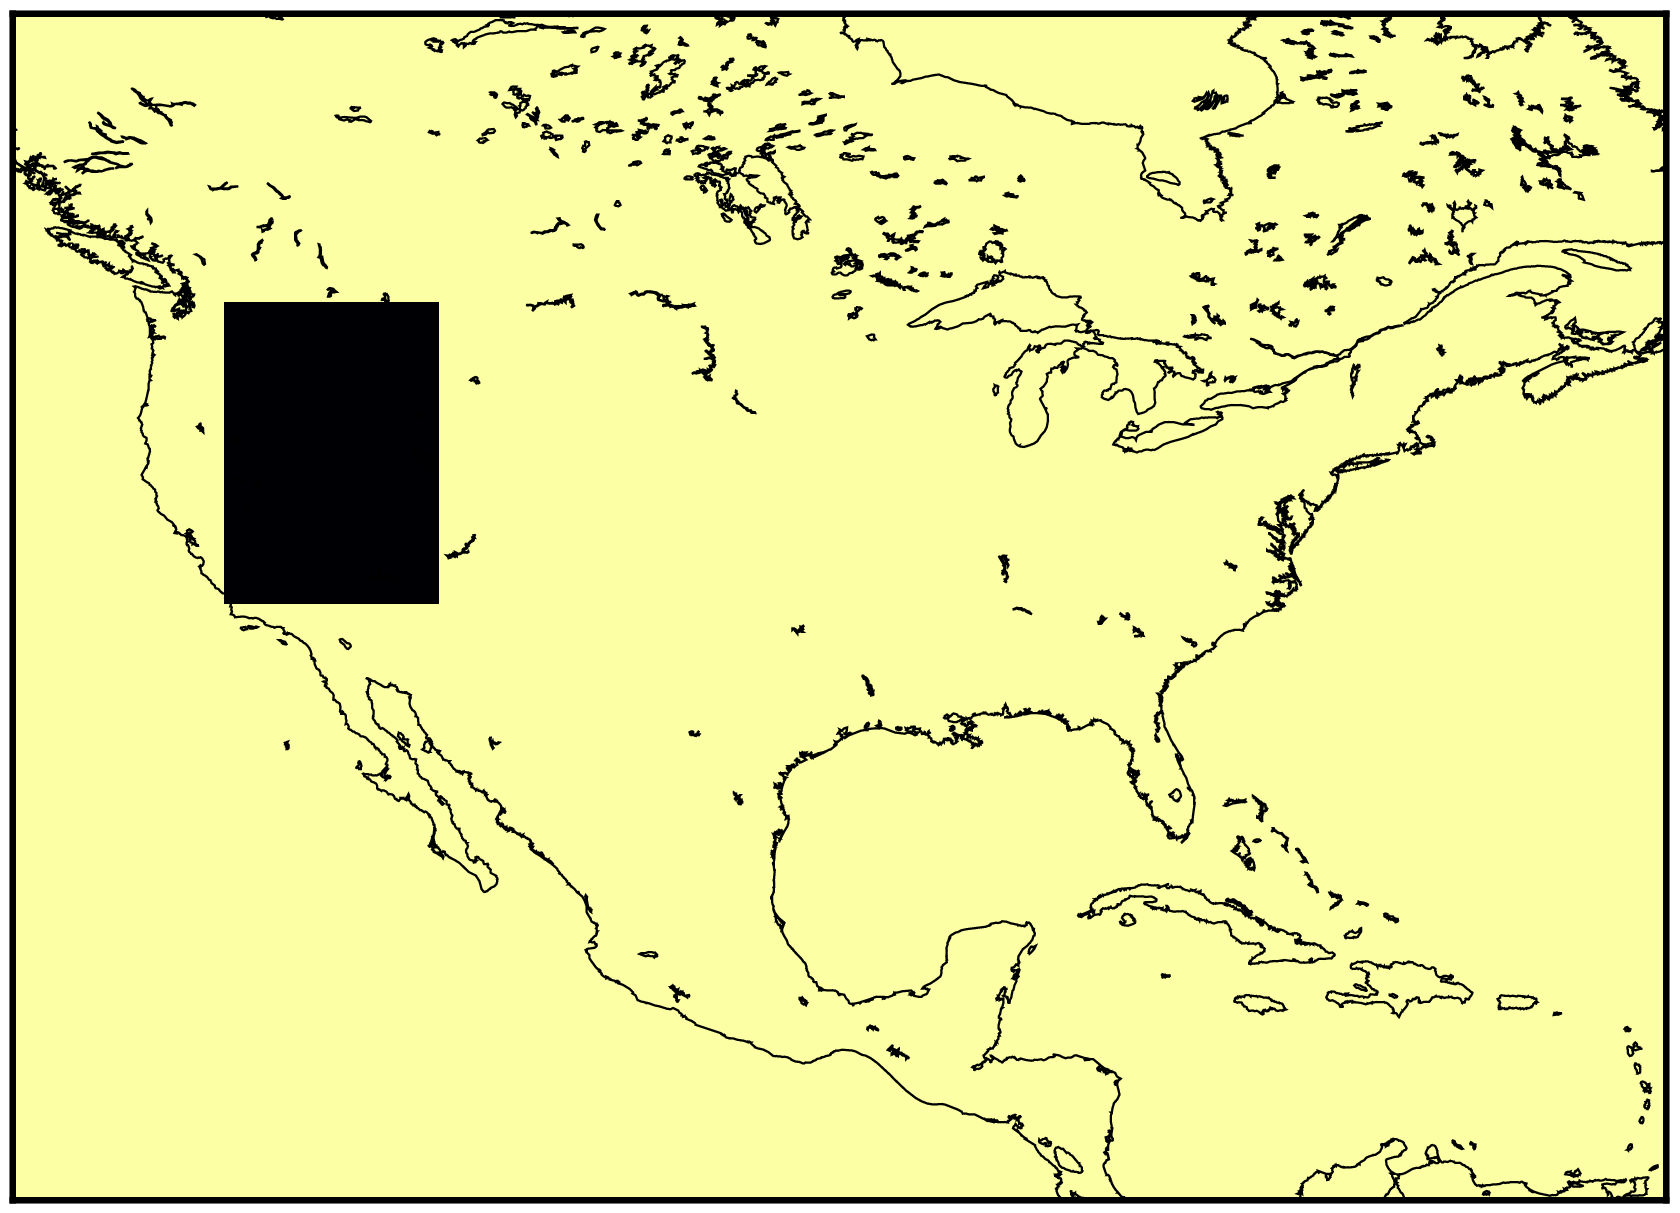

In [43]:
## Visualziation with a coast line - initial condition
G = mat2grid(s11[1:201,1:224]*1e7, x = -130+0.3125/2:0.3125:-60, y = 9.75+0.125:0.25:60)
topo = makecpt(color=:inferno, reverse = true, range=(0,1,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

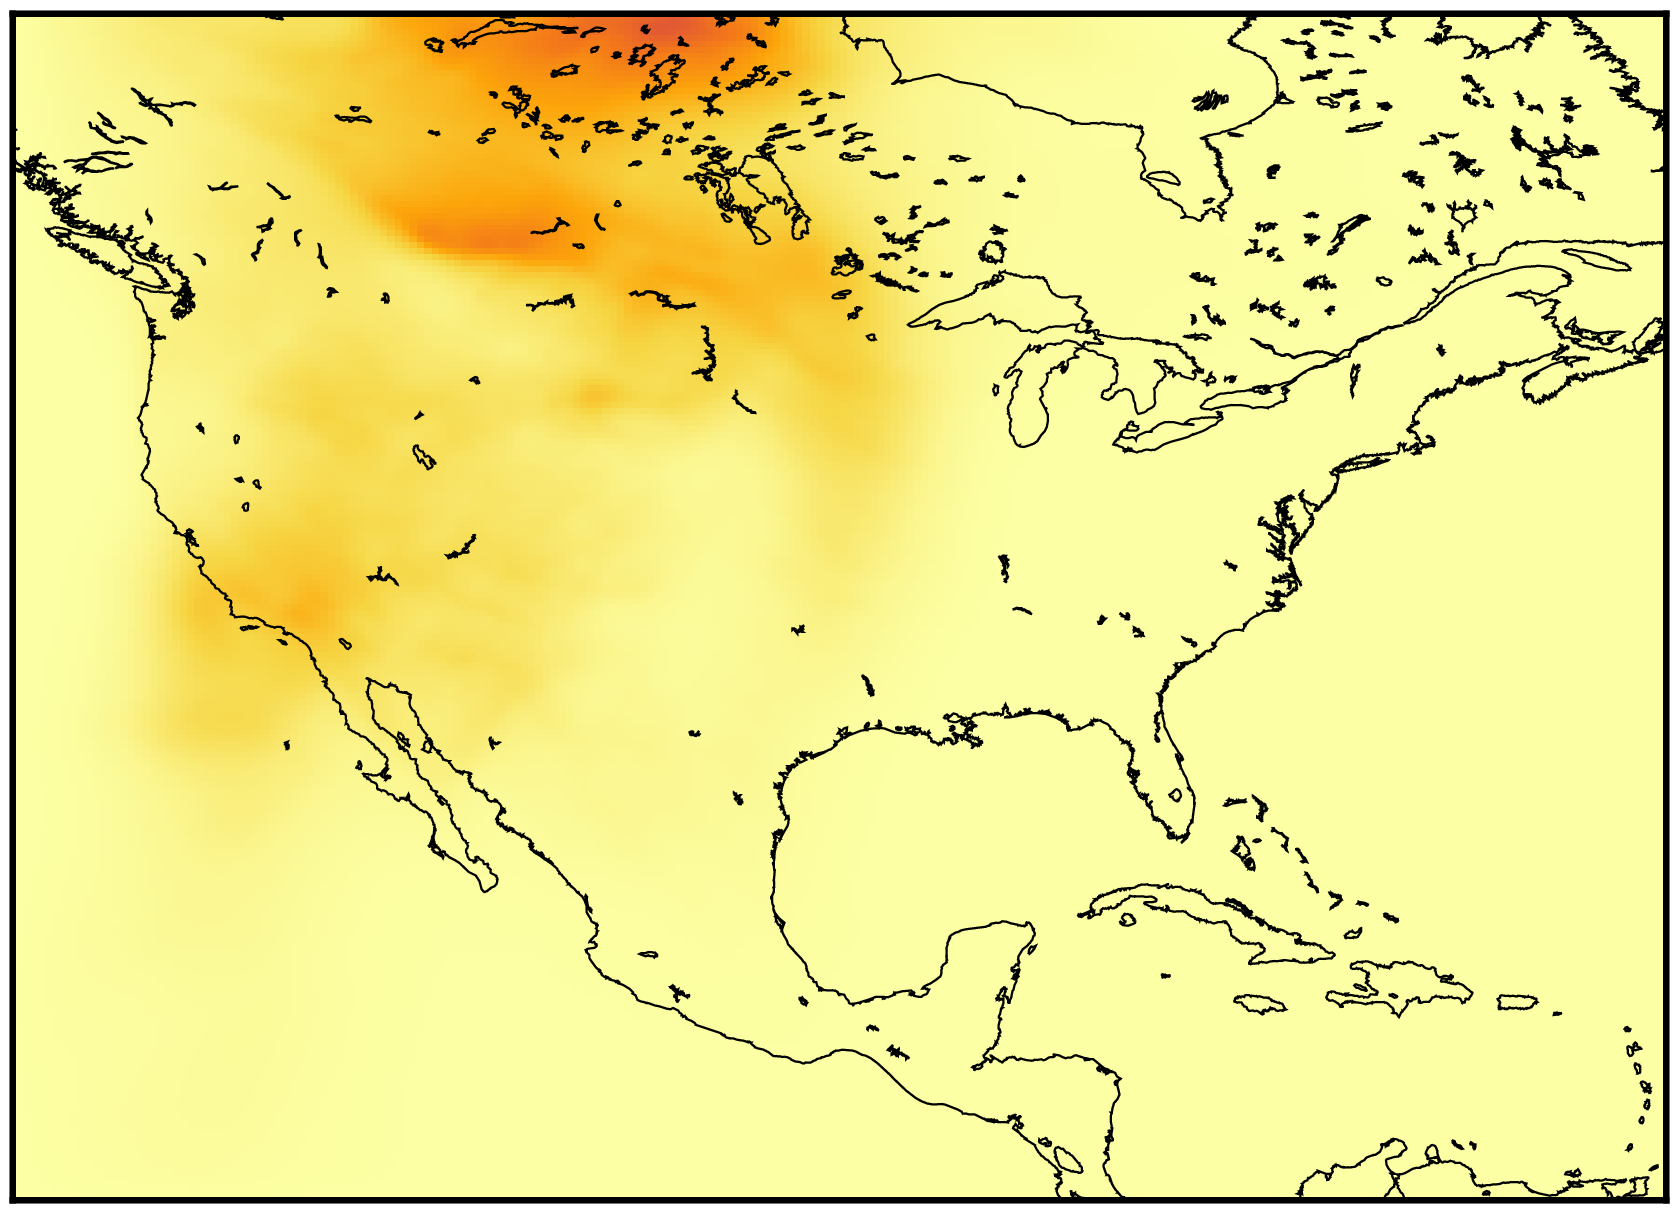

In [40]:
## Visualziation with a coast line - time evolution in 1dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history[1:201,1:224,2880÷5*5]*1e7, x = -130+0.3125/2:0.3125:-60, y = 9.75+0.125:0.25:60)
topo = makecpt(color=:inferno, reverse = true, range=(0,1,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

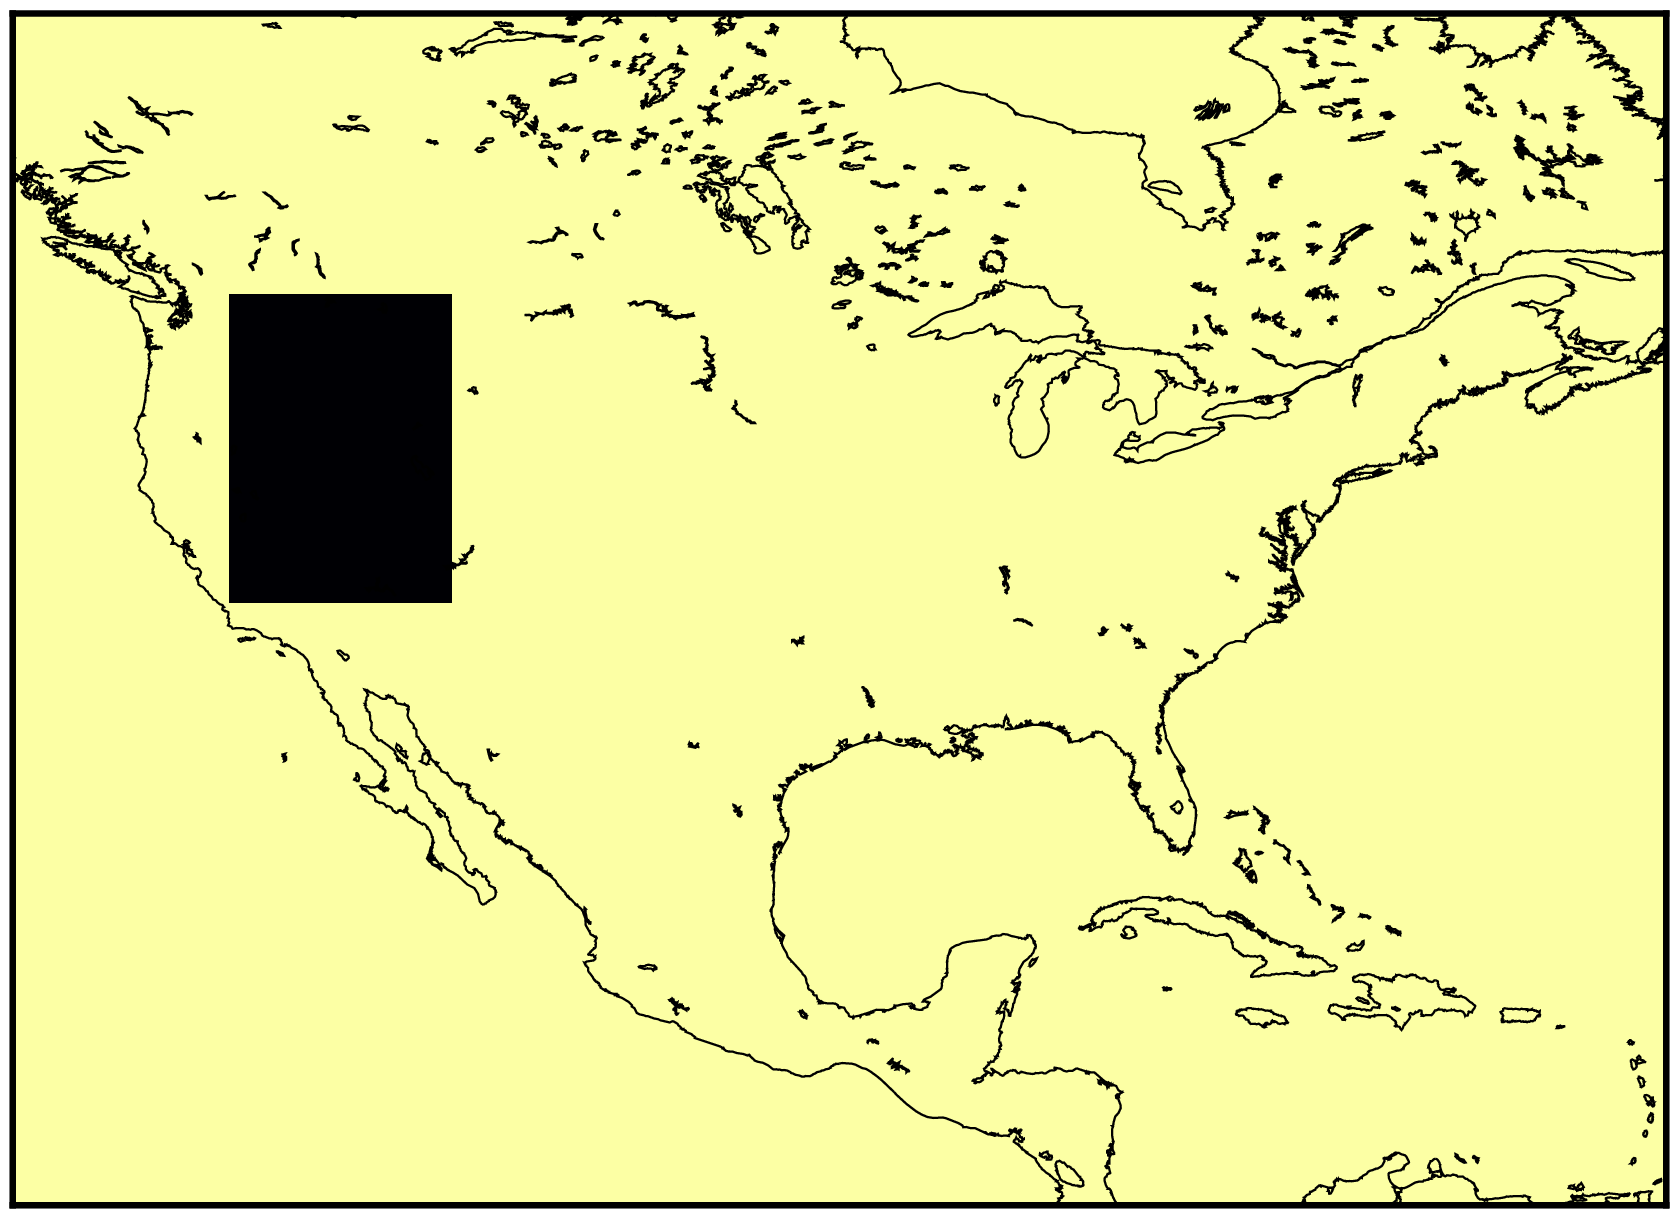

In [35]:
## Visualziation with a coast line - initial condition in 2dx spatial resolution.
G = mat2grid(s11[1:101,1:112]*1e7, x = -130+0.3125*2/2:0.3125*2:-60-0.3125*2/2, y = 9.75+0.125*4:0.25*2:60.75-0.125*4)
topo = makecpt(color=:inferno, reverse = true, range=(0,1,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

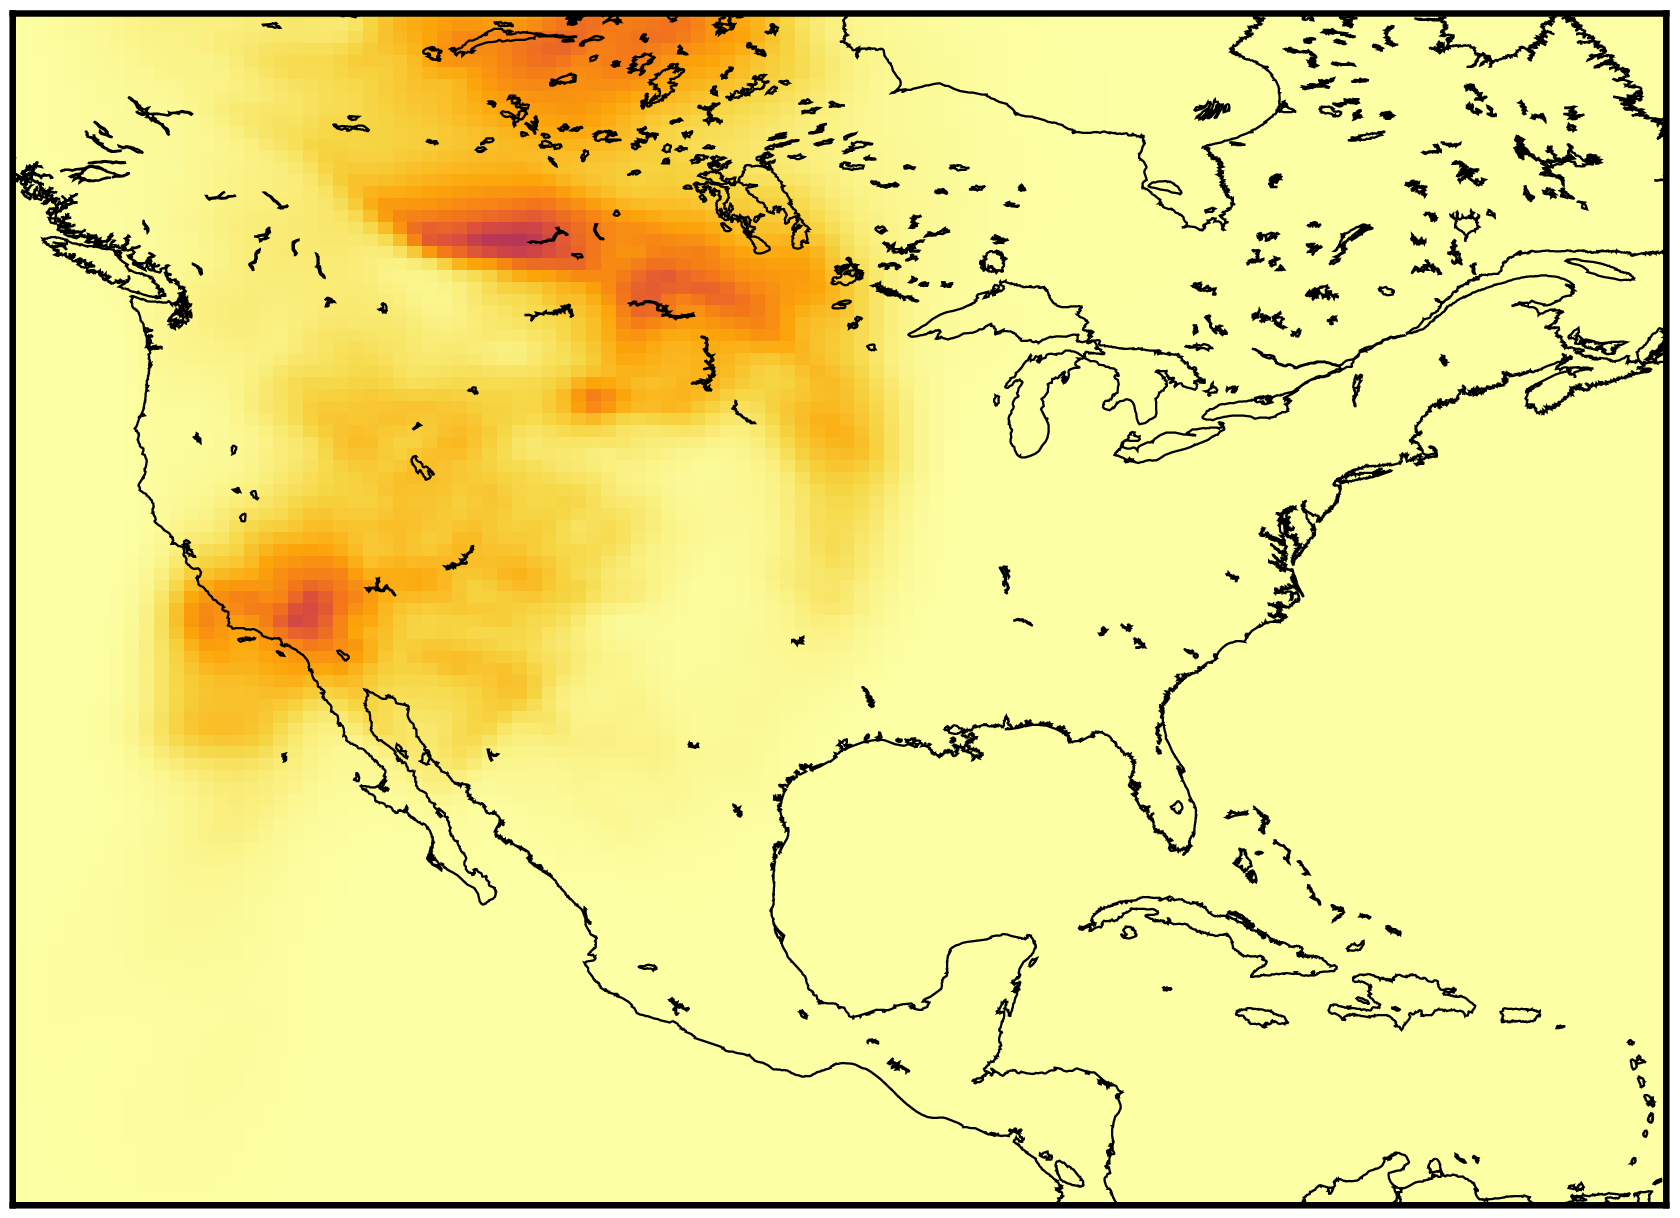

In [51]:
## Visualziation with a coast line - time evolution in 2dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_coarse[1:101,1:112,360÷5*5]*1e7, x = -130+0.3125*2/2:0.3125*2:-60-0.3125*2/2, y = 9.75+0.125*4:0.25*2:60.75-0.125*4)
topo = makecpt(color=:inferno, reverse = true, range=(0,1,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

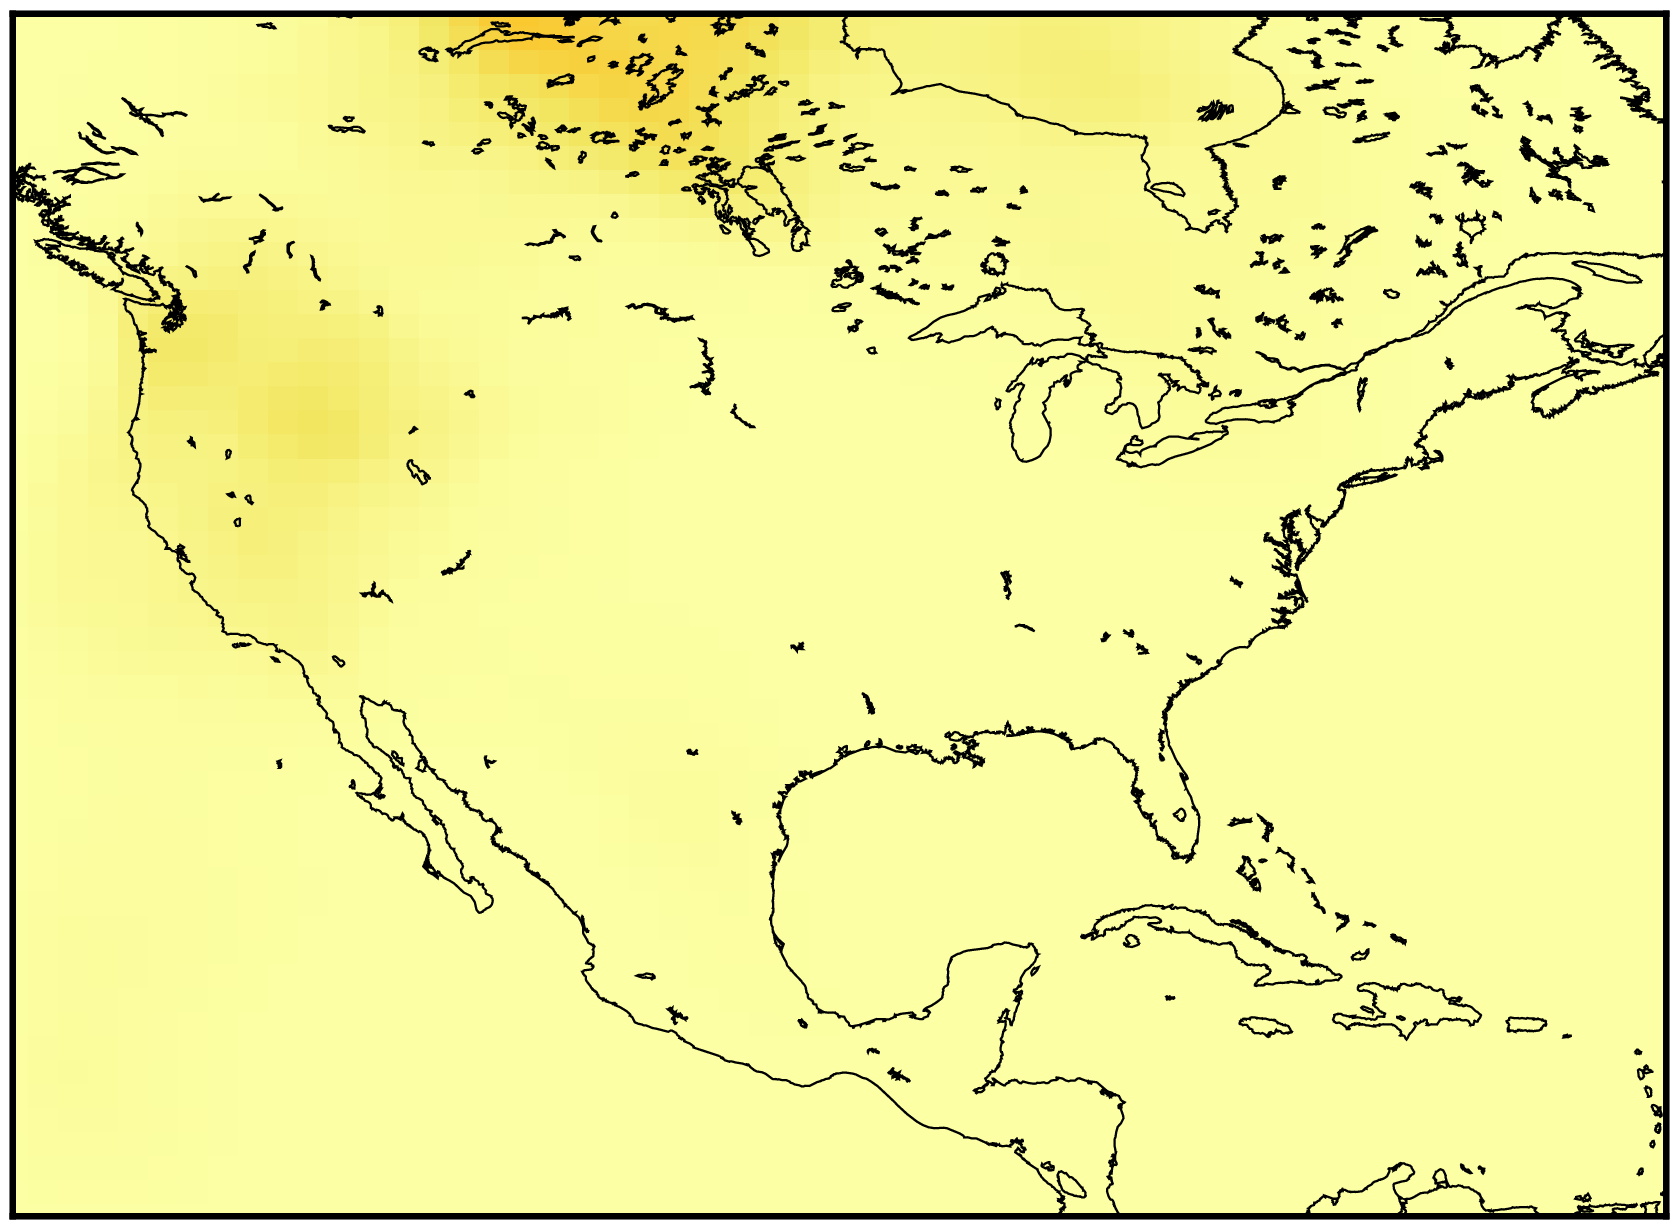

In [33]:
## Visualziation with a coast line - time evolution in 4dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_coarse[1:51,1:56,720÷5*1]*1e7, x = -130+0.3125*4/2:0.3125*4:-60-0.3125*4/2, y = 9.75+0.125*4:0.25*4:60.75-0.125*4)
topo = makecpt(color=:inferno, reverse = true, range=(0,1.5,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

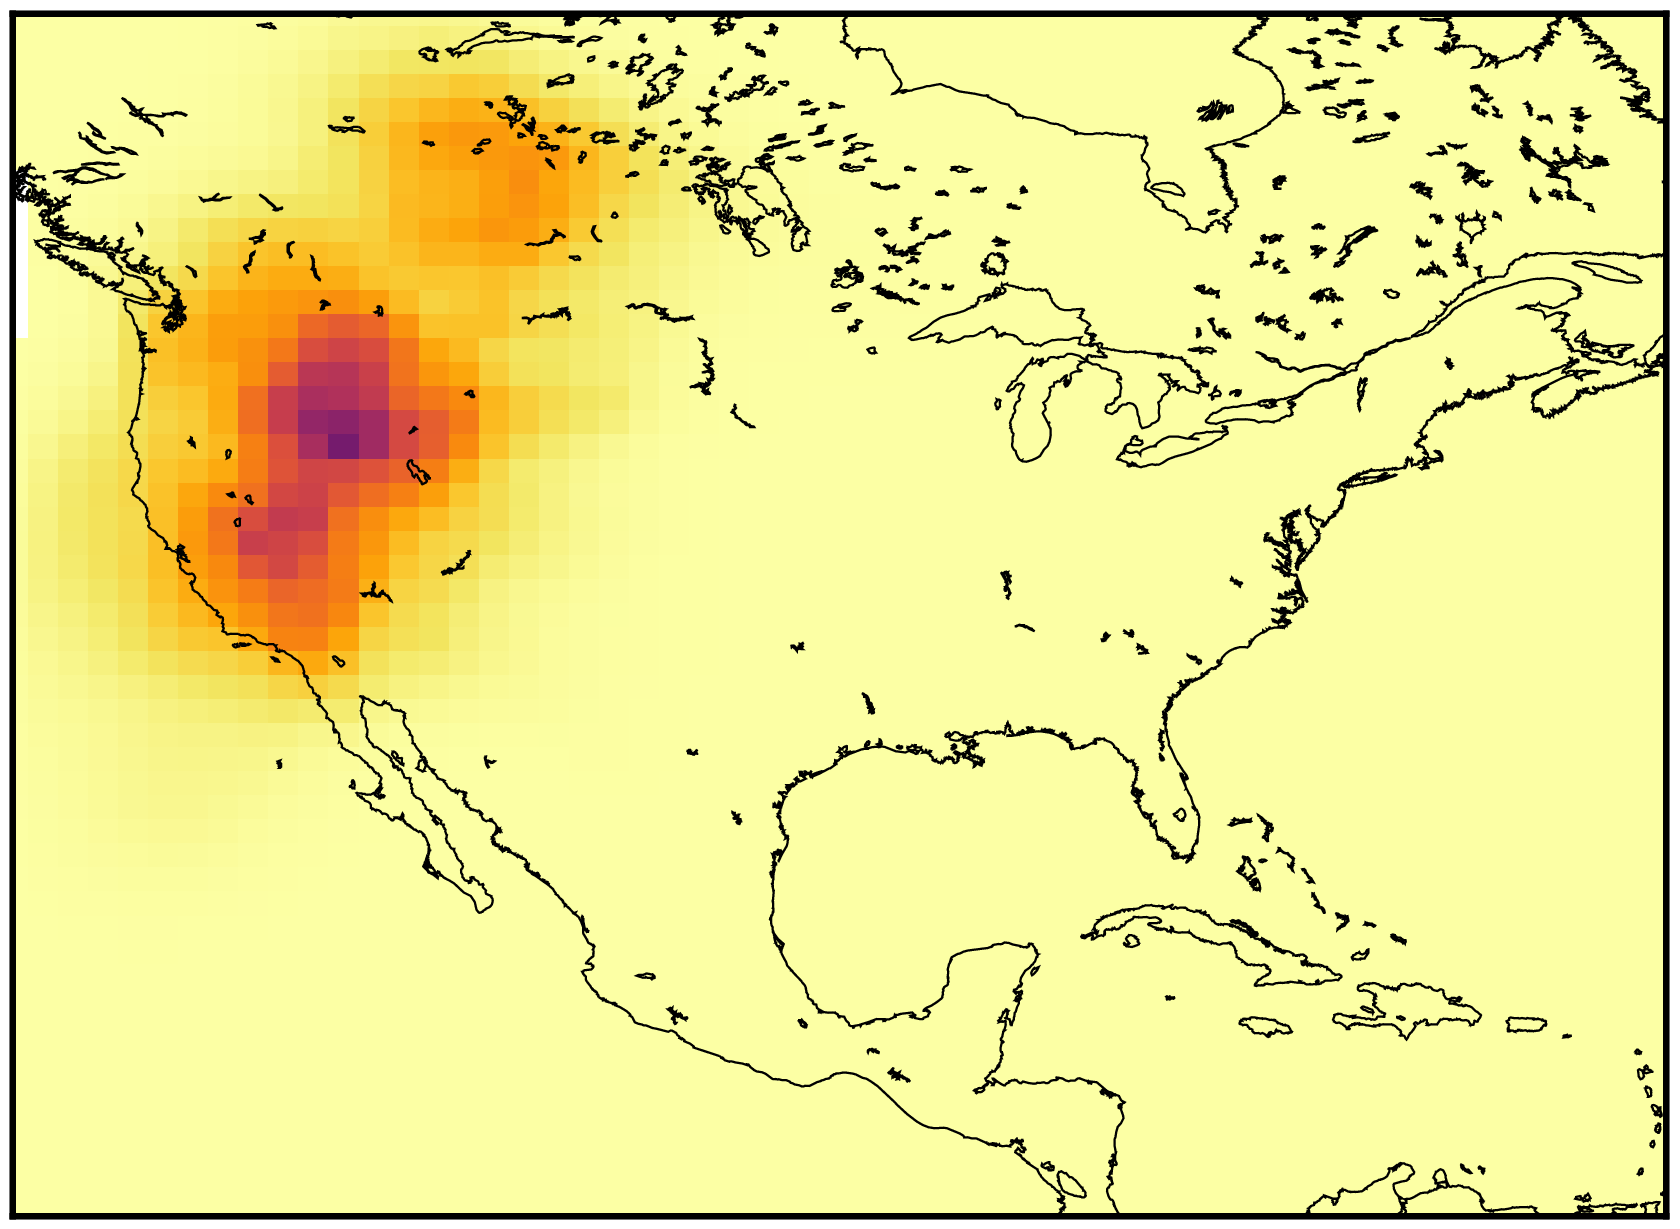

In [34]:
## Visualziation with a coast line - time evolution in 4dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_ml1[1:51,1:56,720÷5*1]*1e7, x = -130+0.3125*4/2:0.3125*4:-60-0.3125*4/2, y = 9.75+0.125*4:0.25*4:60.75-0.125*4)
topo = makecpt(color=:inferno, reverse = true, range=(0,1.5,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

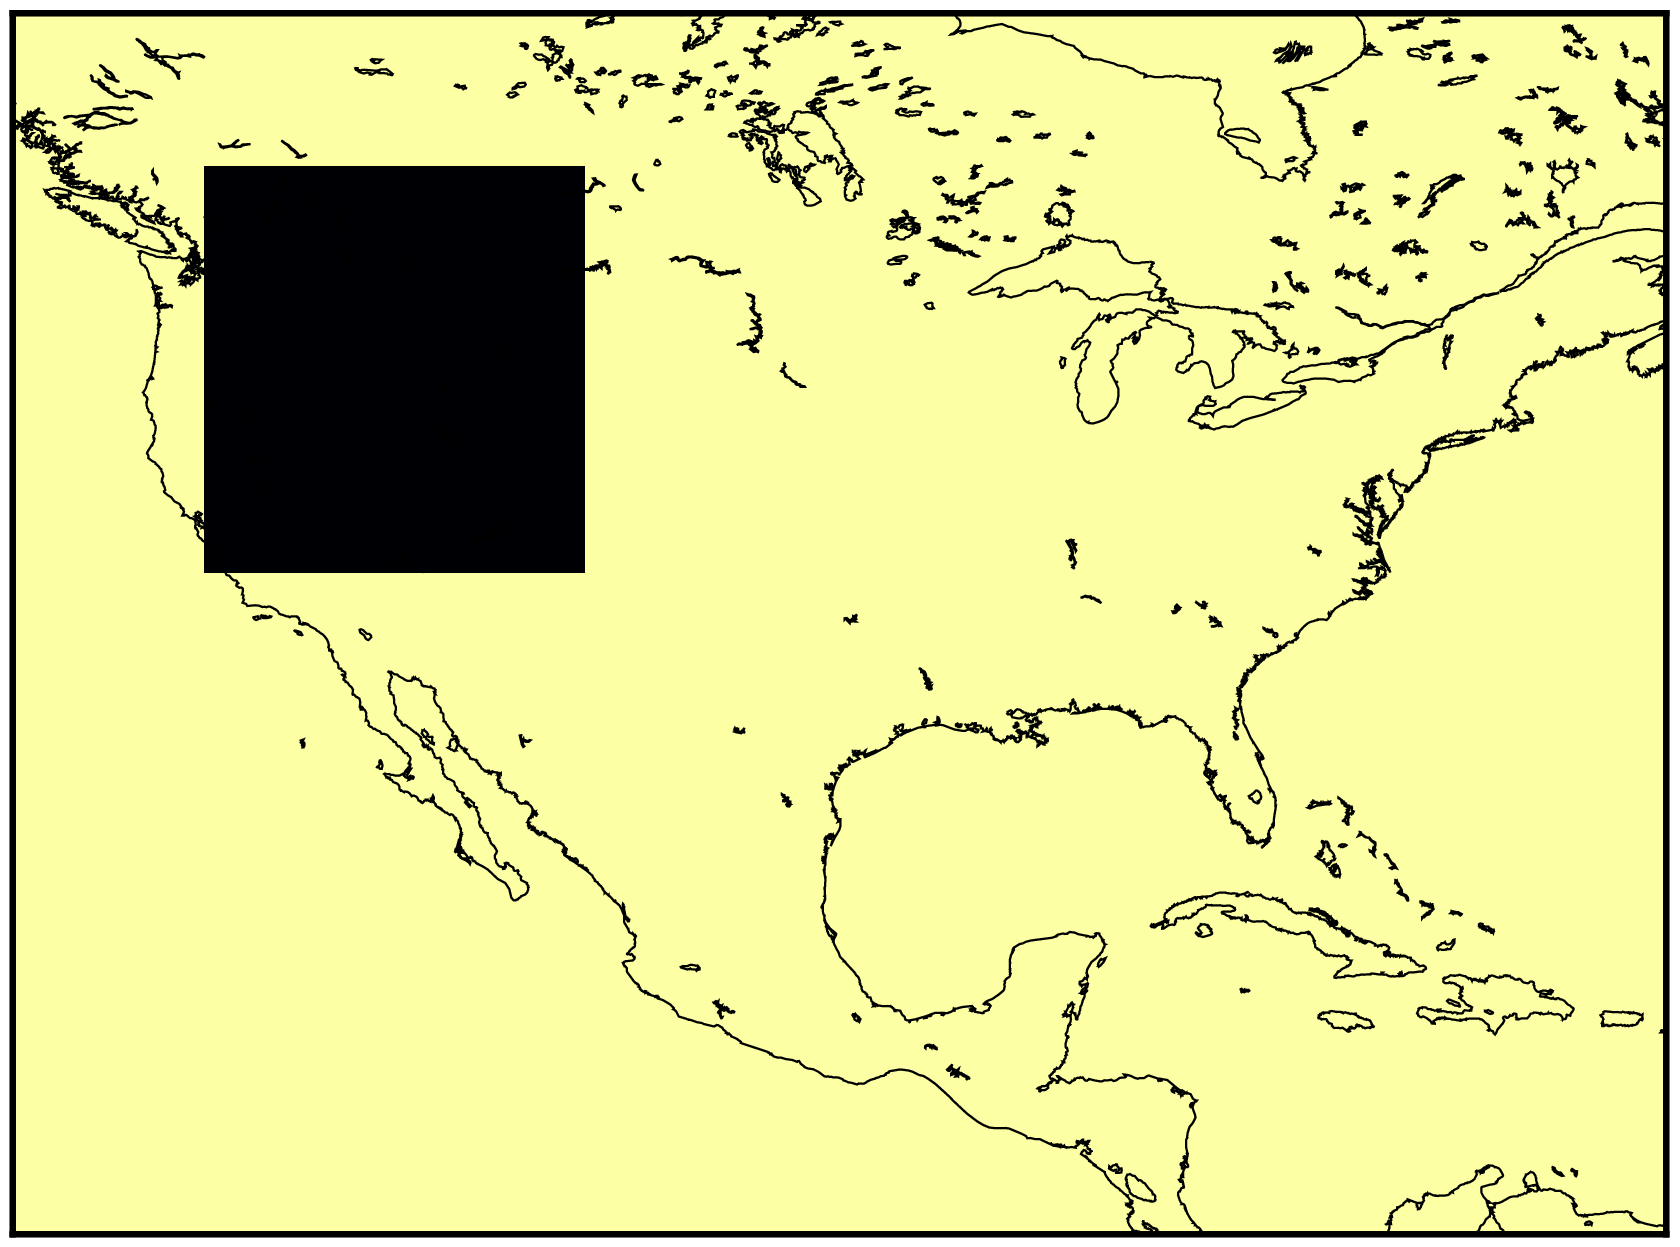

In [61]:
## Visualziation with a coast line - initial condition in 16dx spatial resolution.
G = mat2grid(s11[1:13,1:14]*1e7, x = -130+0.3125:0.3125*16:-60, y = 9.75:0.25*16:60)
topo = makecpt(color=:inferno, reverse = true, range=(0.0,1.0,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

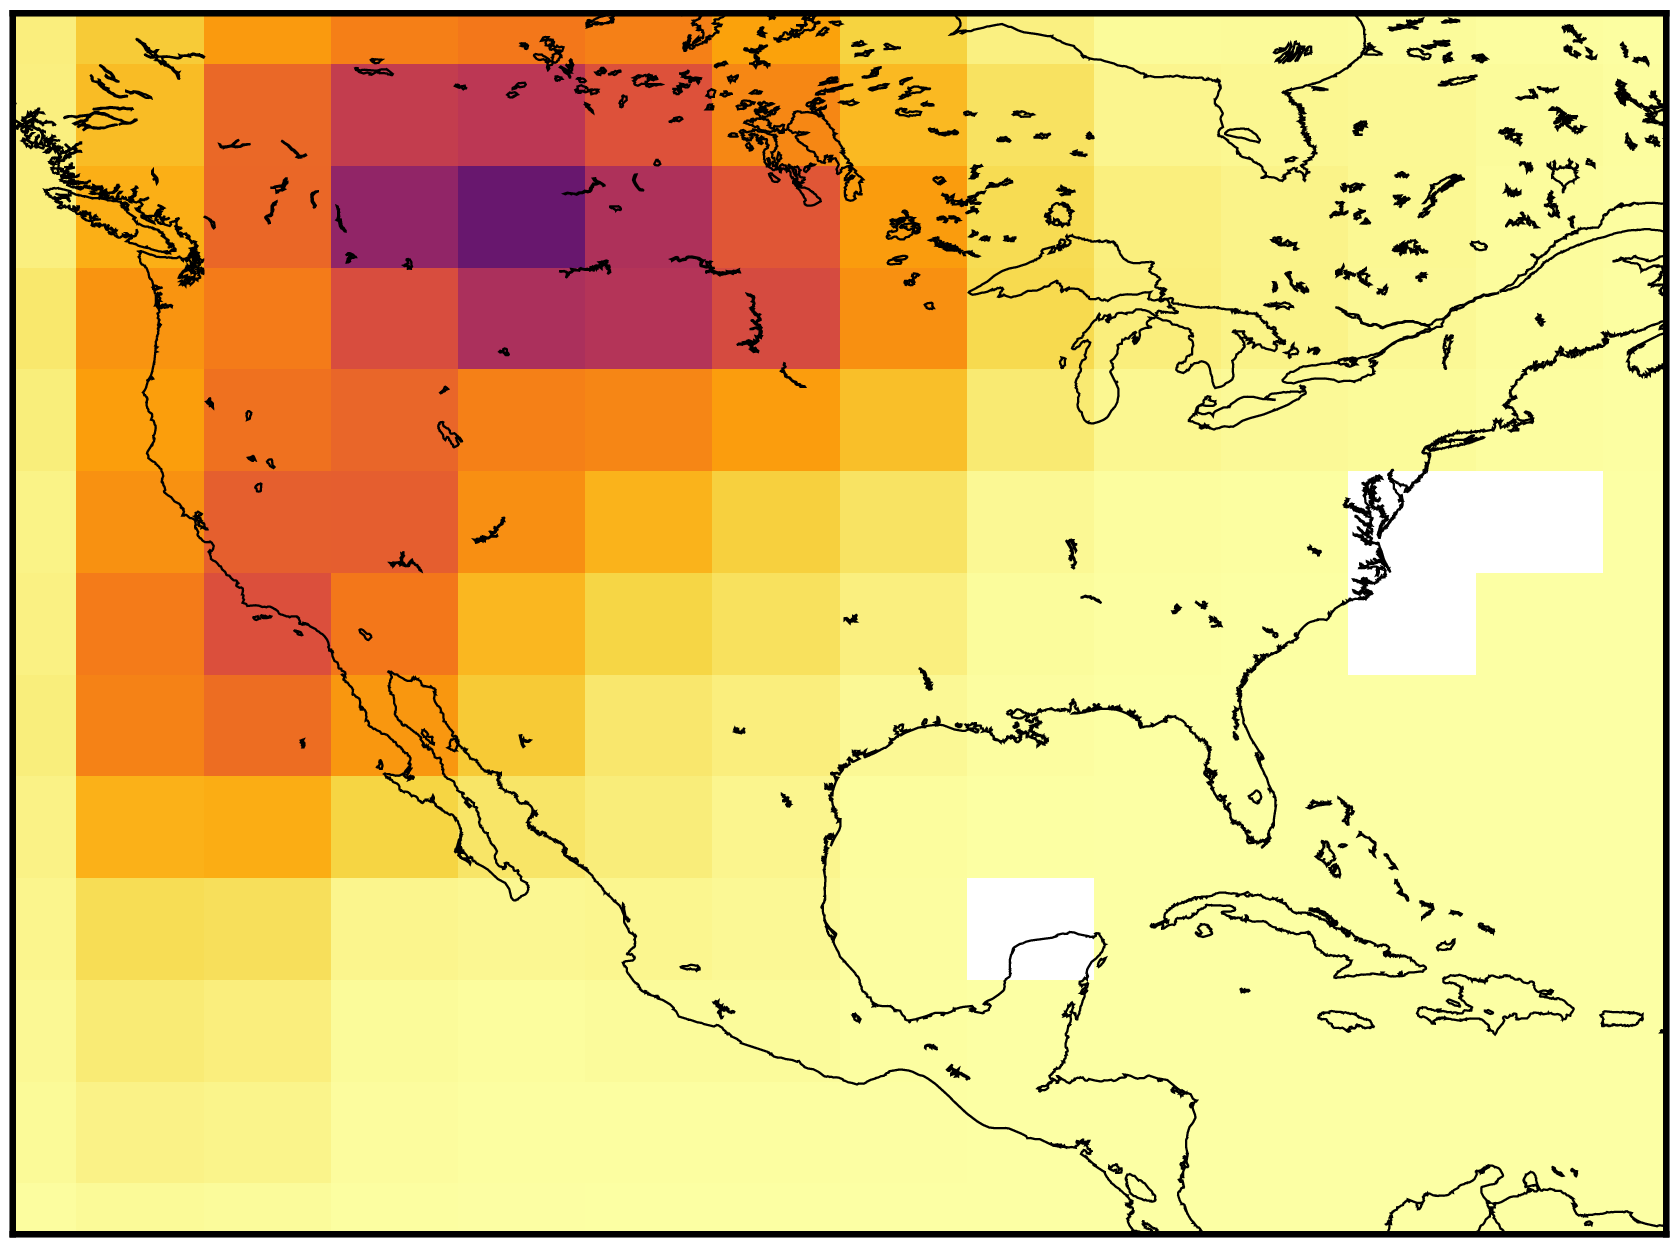

In [85]:
## Visualziation with a coast line - time evolution in 16dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_ml[1:13,1:14,45÷5*5]*1e7, x = -130+0.3125:0.3125*16:-60, y = 9.75:0.25*16:60)
topo = makecpt(color=:inferno, reverse = true, range=(0,1,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

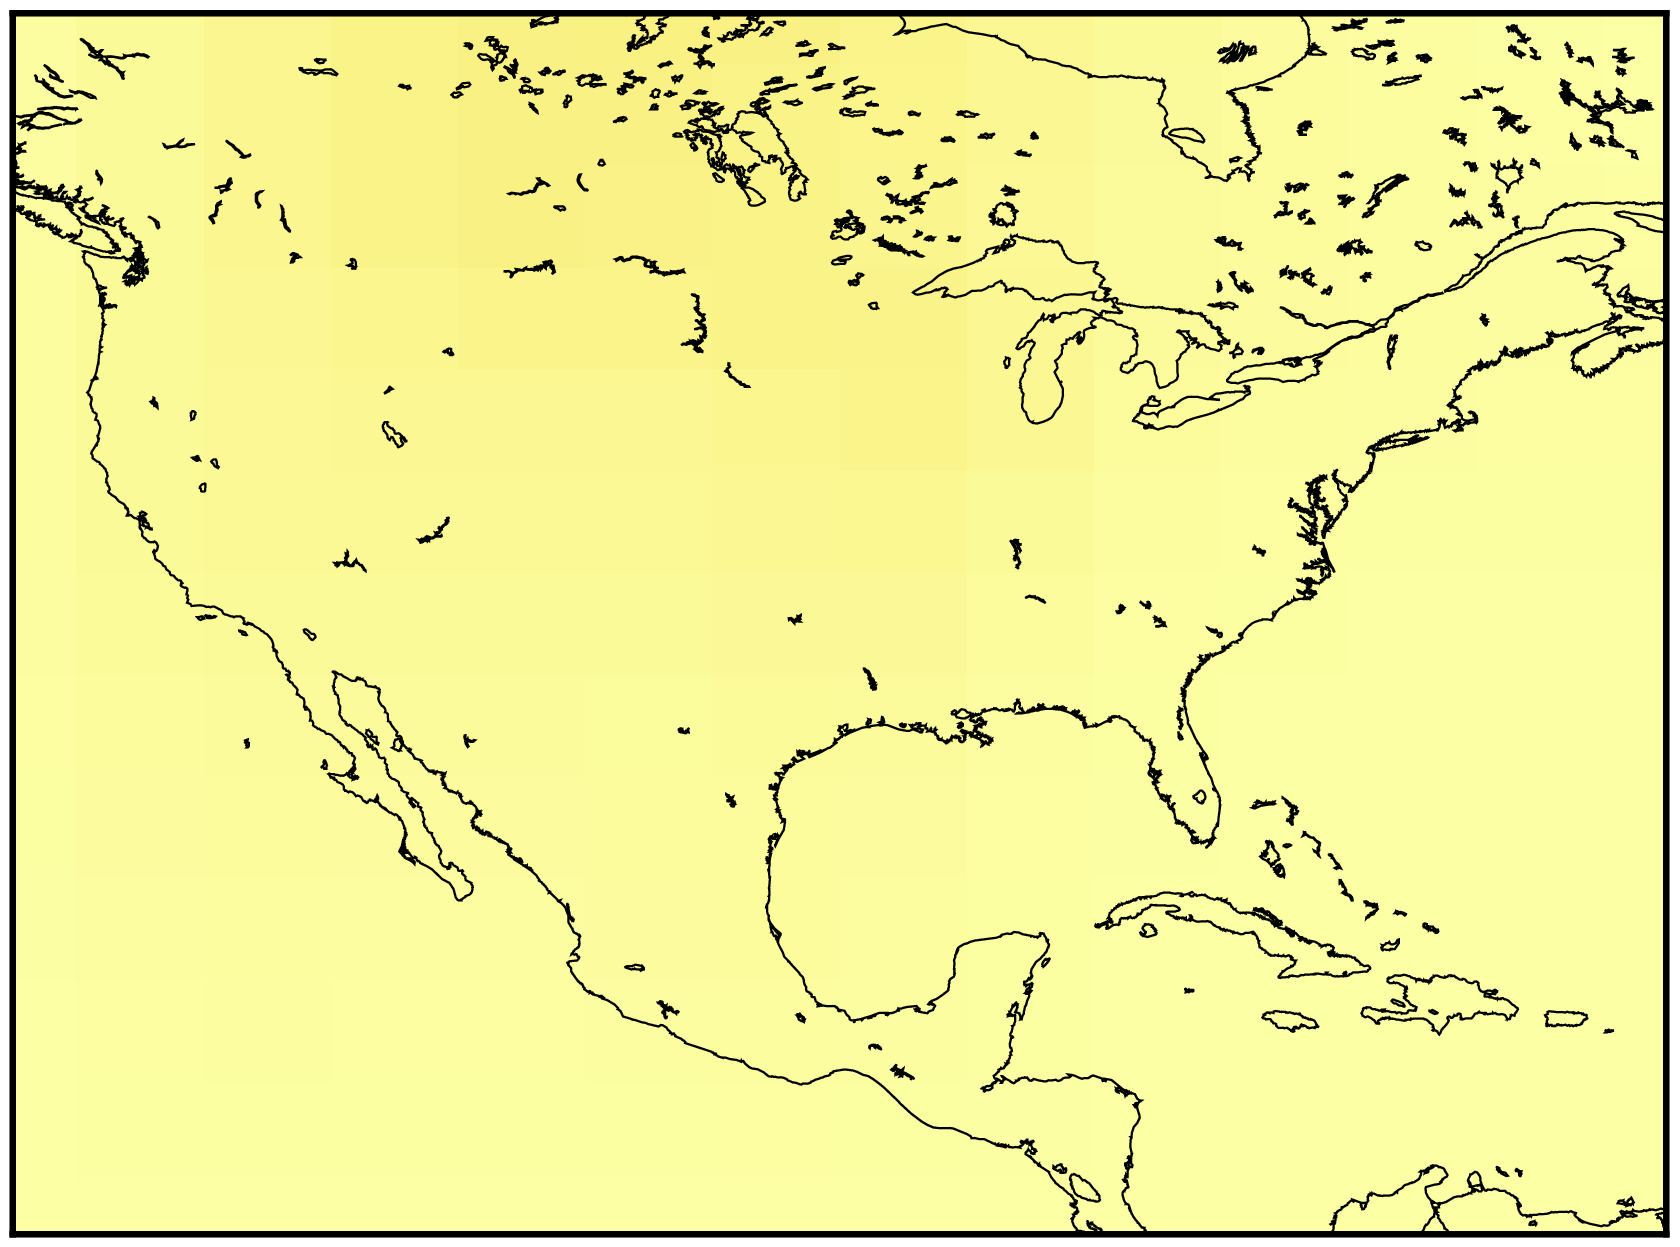

In [39]:
## Visualziation with a coast line - time evolution in 16dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_coarse2[1:13,1:14,45÷5*5]*1e7, x = -130+0.3125*16/2:0.3125*16:-60-0.3125*16/2, y = 9.75:0.25*16:60)
topo = makecpt(color=:inferno, reverse = true, range=(0.0,1.0,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

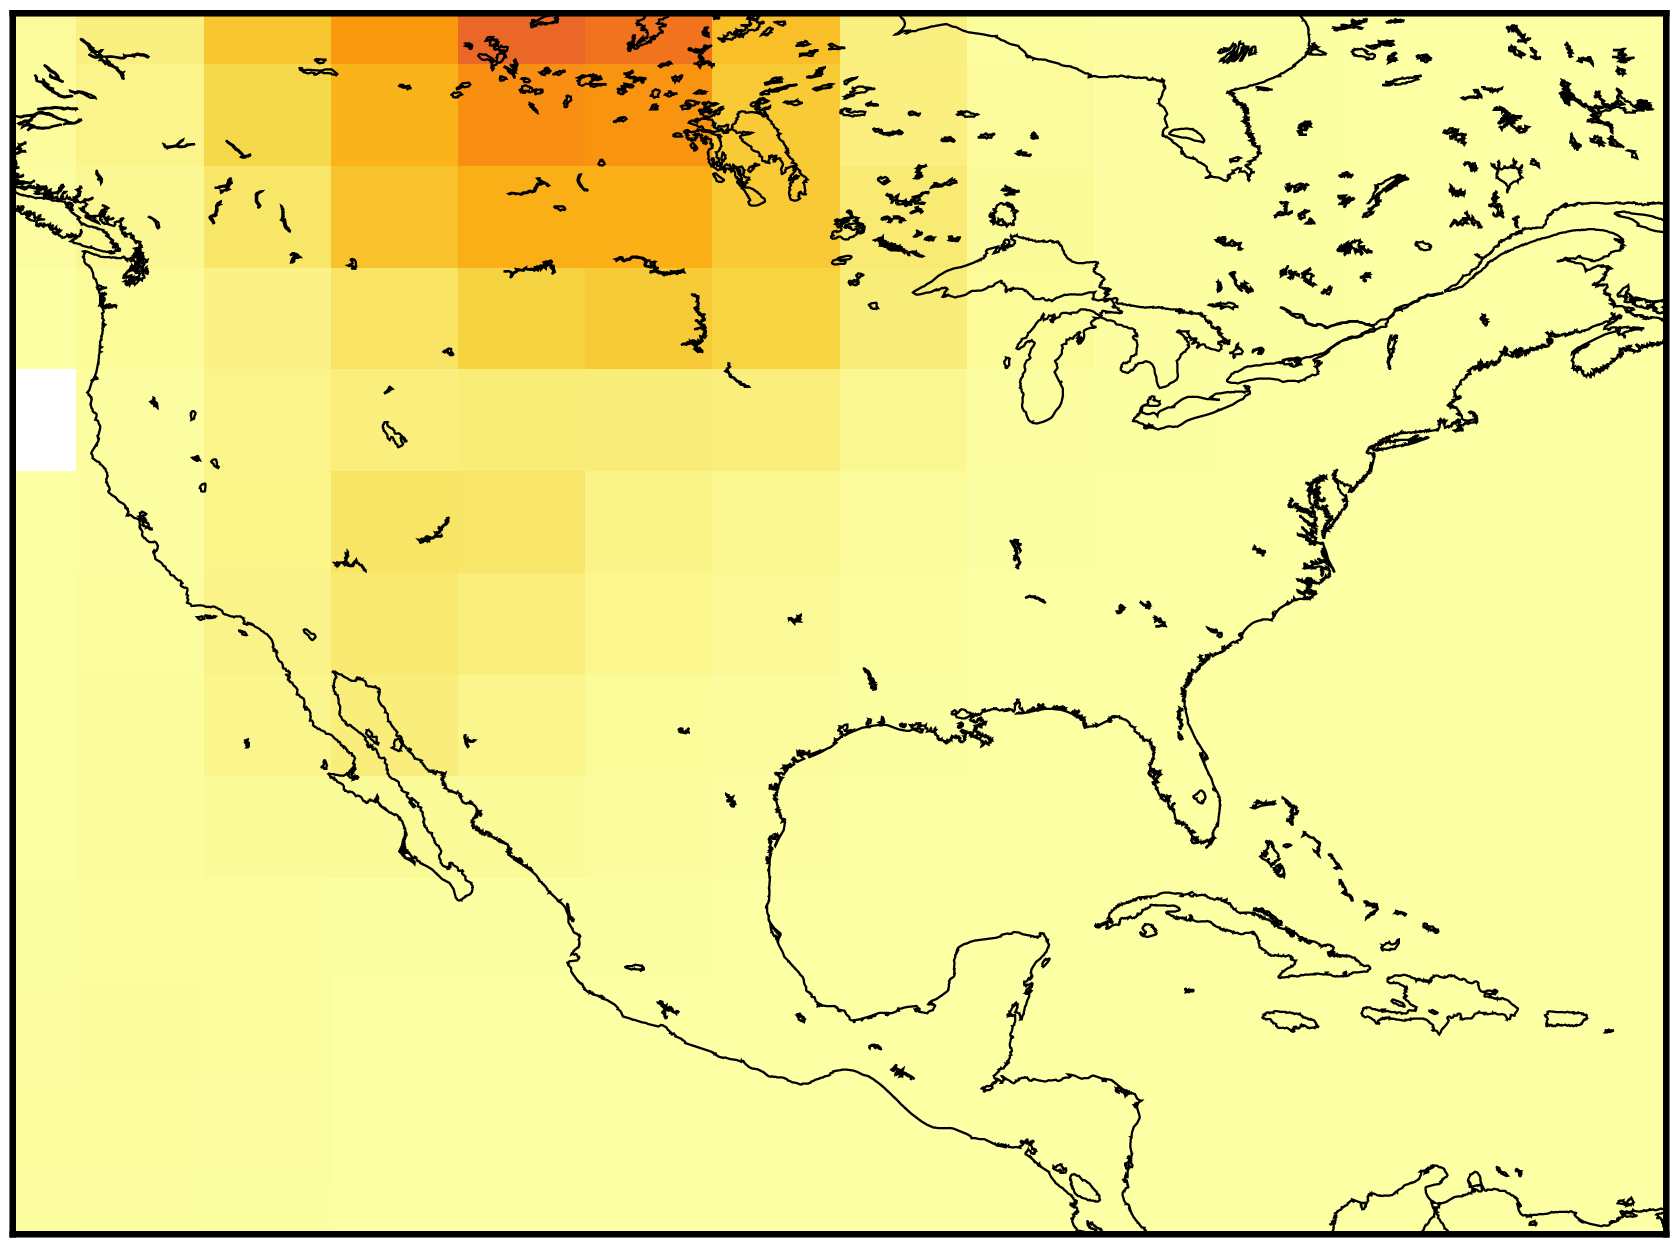

In [44]:
## Visualziation with a coast line - time evolution in 16dx spatial resolution.
## You could change the third dimension number to specify the time you want to see.
G = mat2grid(history_ml2[1:13,1:14,45÷5*5]*1e7, x = -130+0.3125*16/2:0.3125*16:-60-0.3125*16/2, y = 9.75:0.25*16:60)
topo = makecpt(color=:inferno, reverse = true, range=(0,1.0,0.1), continuous=true);
grdimage(G, frame=(annot=false,), color=topo, coast=true, show=true, colorbar=false)

In [90]:
## To see if the range of outputs makes sense - learned advection
maximum(history_ml2), minimum(history_ml2), maximum(history_ml1), minimum(history_ml1)

(1.045521f-7, -7.848783f-10, 1.785171f-7, -5.975259f-10)

In [91]:
## To see if the range of outputs makes sense - baseline
maximum(history), minimum(history)

(1.460689f-7, -1.0f-45)

In [93]:
## To see if the range of outputs makes sense - coarse reference solver
maximum(history_coarse), minimum(history_coarse), maximum(history_coarse2), minimum(history_coarse2)

(4.5513258f-7, 0.0f0, 1.0707377f18, -7.739376f17)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
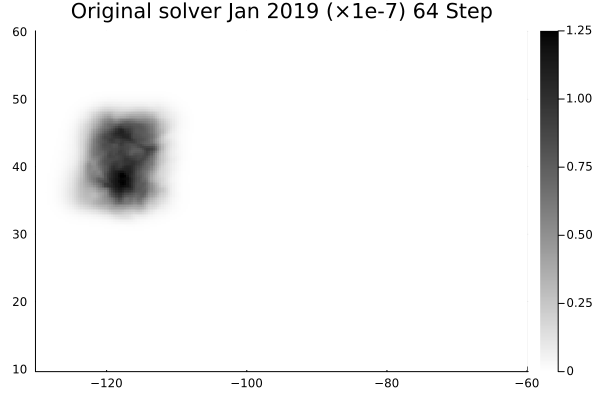

In [47]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    heatmap((-130:0.3125:-60), (9.75:0.25:60), history[1:201,1:224,64*i]*1e7, clims=(0,1.25), title="Original solver Jan 2019 (×1e-7) "*string(64*i)*" Step", c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
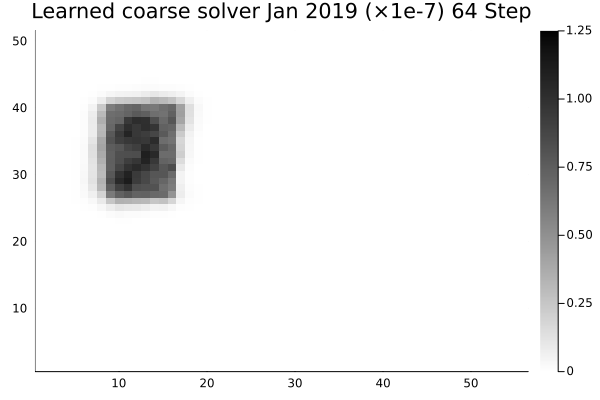

In [70]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    #heatmap(history_ml2[1:13,1:14,i]*1e7, title="Learned coarse solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
    heatmap(history_ml1[1:51,1:56,16*i]*1e7, title="Learned coarse solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
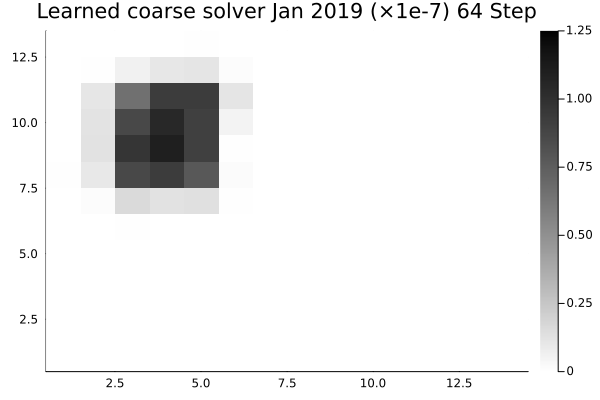

In [61]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    heatmap(history_ml_16x32t[1:13,1:14,2*i]*1e7, title="Learned coarse solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
    #heatmap(history_ml[1:51,1:56,16*i]*1e7, title="Learned coarse solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
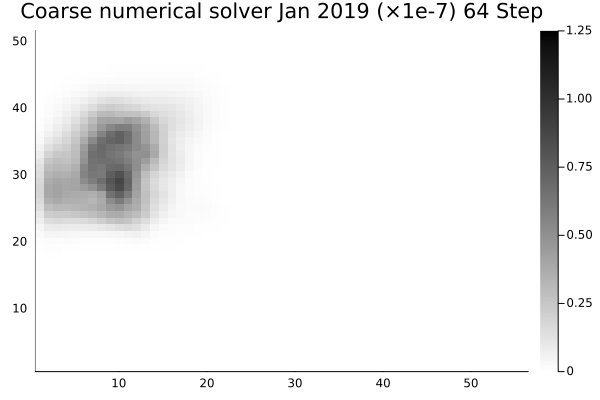

In [87]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    heatmap(history_coarse[1:51,1:56,16*i]*1e7, title="Coarse numerical solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0.0, 1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
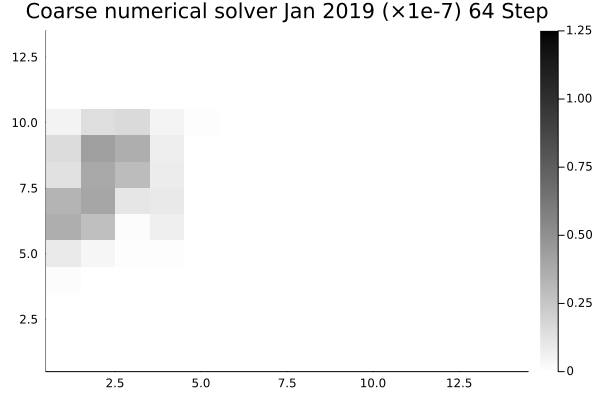

In [88]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    heatmap(history_coarse2[1:13,1:14,i]*1e7, title="Coarse numerical solver Jan 2019 (×1e-7) "*string(64*i)*" Step", clims=(0.0, 1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
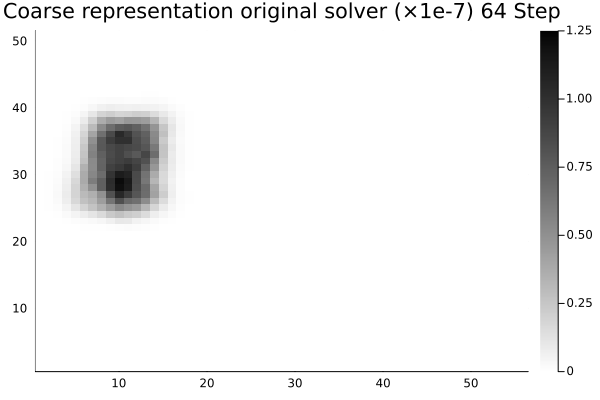

In [78]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    #heatmap(scalar_16x_16y_64t[1:13,1:14,i]*1e7, title="Coarse representation original solver (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
    heatmap(scalar_4x_4y_4t[1:51,1:56,16*i]*1e7, title="Coarse representation original solver (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
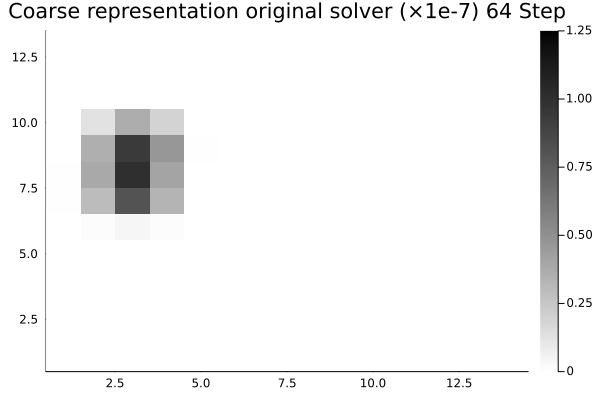

In [79]:
## Visualization in animation
anim = @animate for i ∈ 1:45
    heatmap(scalar_16x_16y_64t[1:13,1:14,i]*1e7, title="Coarse representation original solver (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
    #heatmap(scalar_4x_4y_4t[1:51,1:56,16*i]*1e7, title="Coarse representation original solver (×1e-7) "*string(64*i)*" Step", clims=(0,1.25), c = :grayC)
end
gif(anim, "anim_fps15.gif", fps = 4)

In [27]:
## Evaluating the statistical metrics
## You need to specify the dimension and resolutions
#dim = 26*28*90
dim = 51*56*720 

mae_coarse = StatsBase.L1dist(reshape(scalar_4x_4y_4t, (51*56, 720)), reshape(history_coarse[:,:,1:720], (51*56, 720)))/(dim)
rmse_coarse = StatsBase.L2dist(reshape(scalar_4x_4y_4t, (51*56, 720)), reshape(history_coarse[:,:,1:720], (51*56, 720)))/sqrt(dim)
r2_coarse = Statistics.cor(reshape(scalar_4x_4y_4t, dim), reshape(history_coarse[:,:,1:720], dim))^2
 
#mae_coarse = StatsBase.L1dist(reshape(scalar_4x_4y_4t, (51*56, 720)), reshape(history_coarse[:,:,1:720], (51*56, 720)))/(dim)
#rmse_coarse = StatsBase.L2dist(reshape(scalar_4x_4y_4t, (51*56, 720)), reshape(history_coarse[:,:,1:720], (51*56, 720)))/sqrt(dim)
#r2_coarse = Statistics.cor(reshape(scalar_4x_4y_4t, dim), reshape(history_coarse[:,:,1:720], dim))^2

println("results: ", "   ", mae_coarse, "   ", rmse_coarse, "   ", r2_coarse)

results:    1.884088027439024e-9   4.563722144741967e-9   0.63582677


In [109]:
## In case you want to save the output
# This creates a new NetCDF file /tmp/test.nc.
# The mode "c" stands for creating a new file (clobber)
ds = NCDataset("2D_outputs/learned_16x64t.nc","c")

# Define the dimension "lon" and "lat" with the size 100 and 110 resp.
defDim(ds,"lat",13)
defDim(ds,"lon",14)
defDim(ds,"time",45)

# Define a global attribute
ds.attrib["title"] = "this is a test file"

# Define the variables temperature
v = defVar(ds,"scalar",Float32,("lat","lon","time"))

# Generate some example data
#data = [Float32(i+j) for i = 1:100, j = 1:110]

# write a single column
#v[:,1] = data[:,1]

# write a the complete data set
v[:,:,:] = history_ml2[:,:,1:45]

# write attributes
v.attrib["units"] = "unitless"
#v.attrib["comments"] = "this is a string attribute with Unicode Ω ∈ ∑ ∫ f(x) dx"

close(ds)


closed NetCDF NCDataset

In [38]:
# This creates a new NetCDF file /tmp/test.nc.
# The mode "c" stands for creating a new file (clobber)
ds = NCDataset("2D_velocity/uv_16x64t_3.nc","c")

# Define the dimension "lon" and "lat" with the size 100 and 110 resp.
defDim(ds,"lat",13)
defDim(ds,"lon",14)
defDim(ds,"time",45)

# Define a global attribute
ds.attrib["title"] = "this is a test file"

# Define the variables temperature
u = defVar(ds,"u",Float32,("lat","lon","time"))
v = defVar(ds,"v",Float32,("lat","lon","time"))

# Generate some example data
#data = [Float32(i+j) for i = 1:100, j = 1:110]

# write a single column
#v[:,1] = data[:,1]

# write a the complete data set
u[:,:,:] = U_16x_16y_64t[:,:,:]
v[:,:,:] = V_16x_16y_64t[:,:,:]

# write attributes
v.attrib["units"] = "m/s"
#v.attrib["comments"] = "this is a string attribute with Unicode Ω ∈ ∑ ∫ f(x) dx"

close(ds)

closed NetCDF NCDataset